In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
###Import all Dependencies 
import time
import matplotlib.pyplot as plt
%matplotlib inline
import librosa as lr
from glob import glob
import pandas as pd
import numpy as np
import IPython.display as ipd
#audio,sfreq=lr.load(path,sr=None)
import librosa.display
import seaborn as sns
import sklearn

<b> Data collection </b>

In [0]:
Main_dir = '/content/gdrive/My Drive/sounds/Actor_'
### loop over 24 files, check length of file if length of file is 1 then add 0
### to the prefix and add to the main directory for globing files for actors 01-09,
### if lenght of files greater than 1 then add add to main directory for globing files for actor 10-24
file_data,sampling_rate_file = {},{}
for files in range(1,25):
    if len(str(files))==1:
        data_dir = Main_dir
        data_dir = data_dir+str('0')+str(files)
        #print(data_dir)
    else:
        data_dir = Main_dir
        data_dir = data_dir+str(files)
        #print(data_dir)
    audio_files = glob(data_dir+'/*.wav')
    for i in range(len(audio_files)):
      x= audio_files[i]
      audio,sfreq=lr.load(audio_files[i],sr=None)
      file_data[x]= len(audio)/sfreq
      sampling_rate_file[x]=sfreq
      
data_df=pd.DataFrame()
for keys,values in file_data.items():
    data_df.at[keys,'lengthoffile']=values     

In [0]:
### Create a Function to return the Aduio Data samples and Sampling rate for each file
def audio_data(file):
  audio,sfreq = lr.load(file,sr=None)
  return audio,sfreq



### Create a function to extract Mfcc for a given file
def mfcc_extract(file):
  audio,sfreq = audio_data(file)
  mfccs = librosa.feature.mfcc(audio, sr=sfreq)
  return mfccs


In [0]:
### Empty list
list_data_frame=[]
### Loop over each file path in Data_df dataframe
for file_path in data_df.index:
  data=mfcc_extract(file_path)### call mfcc extract to return mfcc coeffcients and data
  frame=pd.DataFrame(data.T,columns=['mfcc'+str(x) for x in range(0,20)])#### Transform data into (nsamples,n features)
  frame['Actor_Gender_code'] = file_path[38:40]### Extract Actor Gender from file name using defined Encoding
  frame['Emotion_code']=file_path[47:49] #### Extract Emotion code from file name using defined encoding
  frame['Emotional_intensity_code']=file_path[50:52] #### Extract Emotional Intensity code using identified encoding
  list_data_frame.append(frame)
  
  
  
### Final Data Frame
merged_df = pd.concat(list_data_frame,ignore_index=True)

### Create Male female from gender code , odd is male and even is female
merged_df["Gender_label"] = list(map(lambda x: 'Male' if int(x)%2==1 else 'Female',merged_df.Actor_Gender_code))

### Emotion label for various classes 
merged_df['Emotion_label']=merged_df.Emotion_code.map({'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'})
### Emotional Intensity normal or strong
merged_df['Intensity_label']=merged_df.Emotional_intensity_code.map({'01':'normal','02':'strong'})

In [0]:
### Create emotion + gender label
merged_df['Gender_emotion_Label']=merged_df['Gender_label']+"_"+merged_df['Emotion_label']
model_df = merged_df

<b>Data Exploration </b>

In [0]:
print(f'Preview of data')
model_df.head()

Preview of data


,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,Actor_Gender_code,Emotion_code,Emotional_intensity_code,Gender_label,Emotion_label,Intensity_label,Gender_emotion_Label
0,-861.532578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,01,01,Male,neutral,normal,Male_neutral
1,-861.532578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,01,01,Male,neutral,normal,Male_neutral
2,-861.532578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,01,01,Male,neutral,normal,Male_neutral
3,-861.532578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,01,01,Male,neutral,normal,Male_neutral
4,-861.532578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,01,01,01,Male,neutral,normal,Male_neutral


<li> Check data Distribution by Gender</li>

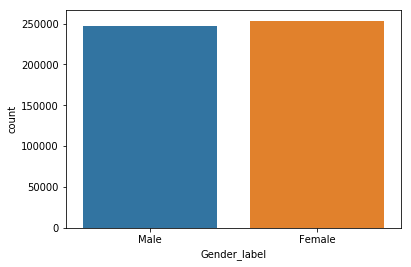

In [0]:
_=sns.countplot(x='Gender_label',data=model_df)

<li>We see the number of samples for Female are Highed in the data set</li>
<li> Check data Distribution by Emotion</li>

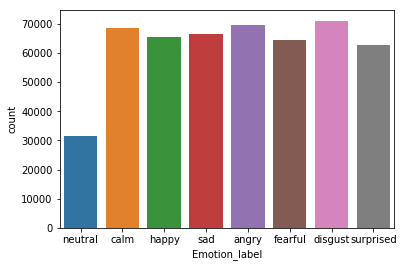

In [0]:
_=sns.countplot(x='Emotion_label',data=model_df)

<li>We see the number of samples for each emotion is unbalancedin the data set</li>
<li> Check data Distribution by Gender  and Emotion</li>


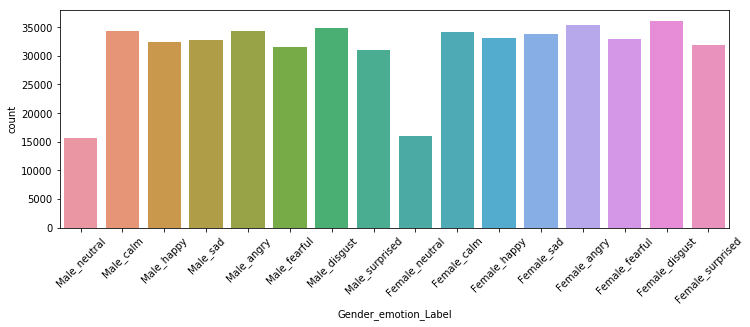

In [0]:
plt.figure(figsize=(12,4))
sns.countplot(x='Gender_emotion_Label',data=model_df)
_=plt.xticks(rotation=45)

<b> Using K means clusters to see if distinct clusters can be formed with the data and Visualizing Clusters using PCA in two dimensions to chose optimum clusters to describe the data</b>


In [0]:
### Create a scaled cluster data frame from main DF(model_df)
z_scaler = sklearn.preprocessing.StandardScaler()
scaled_data=z_scaler.fit_transform(model_df[model_df.columns[:-7]].values)

In [0]:
### import Dependencies
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn






<li>Choosing K: The Elbow Sum-of-Squares Method</li>

In [0]:
### Function to find best K
def best_k(k=2):
    #print(k)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    return kmeans.inertia_
  

In [11]:
my_dict={}
### Loop over for potential k  
for i in range(2,10):
    my_dict[i]=best_k(i)
    
for k,ss in my_dict.items() :
  print(f'For each k = {k} the SS is = {ss}')

For each k = 2 the SS is = 7814313.978960489
For each k = 3 the SS is = 7232396.897739263
For each k = 4 the SS is = 6861279.654496308
For each k = 5 the SS is = 6539341.351734245
For each k = 6 the SS is = 6271279.623656985
For each k = 7 the SS is = 6047101.987150754
For each k = 8 the SS is = 5866248.227024902
For each k = 9 the SS is = 5711011.1810371475


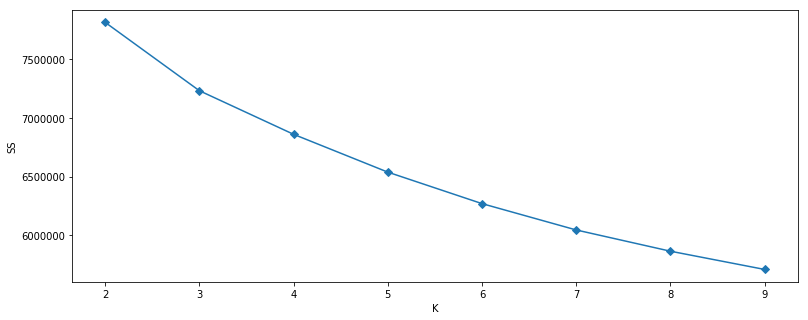

In [14]:
plt.figure(figsize=(13,5))
plt.plot(list(my_dict.keys()),list(my_dict.values()),marker='D')
plt.xlabel('K')
plt.ylabel('SS')
plt.show()

<li> As seen from elbow plot  Graph above its very difficult to get a a good value for K</li>

<b> Using PCA to plot clusters </b>

In [0]:
marker=['.',',','o','v','^','<','>','1','2','3','4','8','s','p','P','*','h','H','+','x','X','D','d','|','_']
pca= PCA(n_components=2)
def pca_calc(n_clusters=2):
  clusters = KMeans(n_clusters).fit_predict(scaled_data)
  return clusters,pca.fit_transform(scaled_data)
 
def plot_pca(df,k):
  plt.figure(figsize=(20,15))
  _=sns.lmplot(x='First PCA component',y='Second PCA component',data=df,hue='cluster',fit_reg=False,legend=False,palette="Set2",markers=marker[:k])
  plt.title(f'Cluster representation by 2 principal components for k ={k}')
  plt.tight_layout()
  plt.show()
  

<Figure size 1440x1080 with 0 Axes>

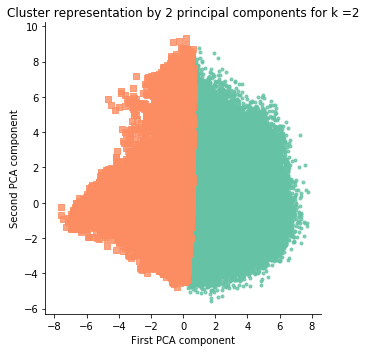

<Figure size 1440x1080 with 0 Axes>

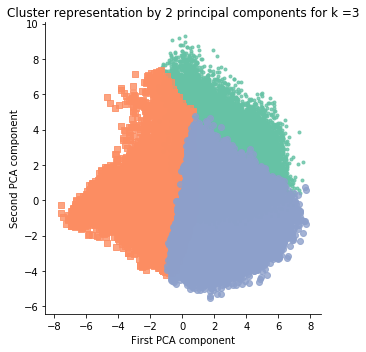

<Figure size 1440x1080 with 0 Axes>

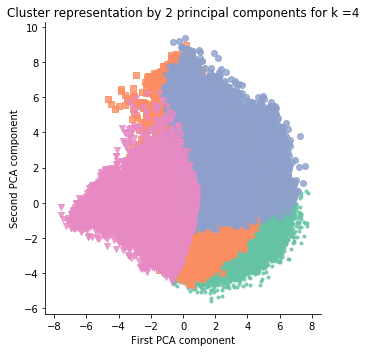

<Figure size 1440x1080 with 0 Axes>

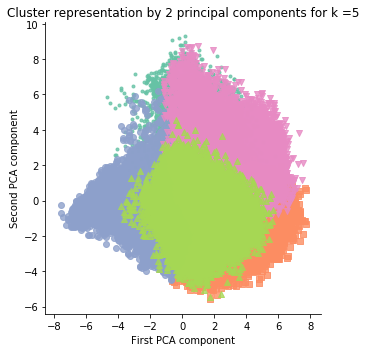

<Figure size 1440x1080 with 0 Axes>

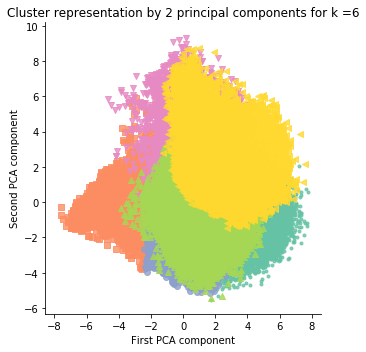

<Figure size 1440x1080 with 0 Axes>

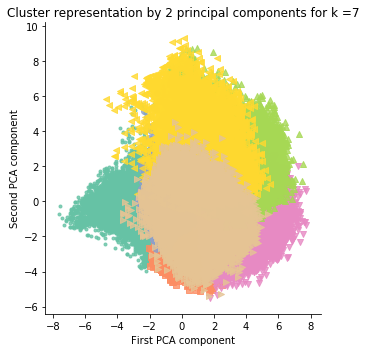

<Figure size 1440x1080 with 0 Axes>

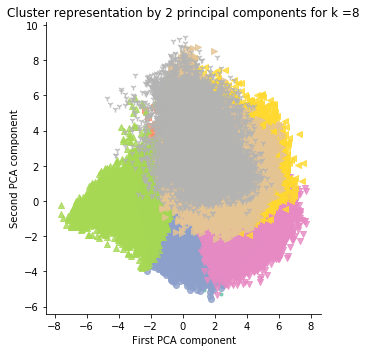

<Figure size 1440x1080 with 0 Axes>

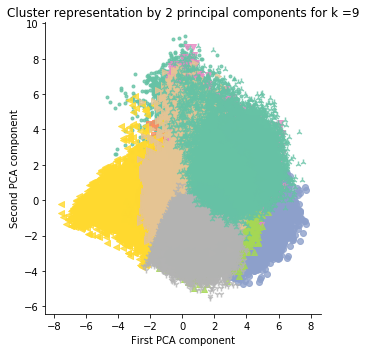

In [13]:
for n_clusters in range(2,10):
  clusters,pca_cordinates = pca_calc(n_clusters)
  pca_df=pd.DataFrame({'cluster':list(clusters),'First PCA component':pca_cordinates[:,0],'Second PCA component':pca_cordinates[:,1]})
  plot_pca(pca_df,n_clusters)
  

<li> We can see from the above plots that there are some some well defined boundary even with higher number of clusters </li>

<b> Choose best model for classification of Gender </b>

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
import xgboost
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

<li> Create X and y </li>
<li>encode the label using labelencoder</li>

In [0]:
y = LabelEncoder().fit_transform(model_df['Gender_label'])
X = model_df[model_df.columns[:-7]].values

<li>split the data into train_test split</li>

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,stratify=y,shuffle=True)
fitted = z_scaler.fit(X_train)
X_train = fitted.transform(X_train)
X_test = fitted.transform(X_test)

<li>Create a list of classifier to evaluate performance of various classifiers on the data using metrics such as confusion matrix and accuracy score </li>

In [18]:
## dict of classifiers 
classifiers= {'XGboost':xgboost.XGBClassifier(),'DecisonTree':tree.DecisionTreeClassifier(),'RandomForest':RandomForestClassifier()}

### Iterate over all classifiers and evaluate performance 
def performance(classifiers,X_train,X_test,y_train,y_test):
  for k,clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy of {k} classifier is {acc}')
    cm = confusion_matrix(y_test, y_pred)
    print(f'confusion matrix')
    print(cm)
          
performance(classifiers,X_train,X_test,y_train,y_test)        

Accuracy of XGboost classifier is 0.7920954601895878
confusion matrix
[[67959 15670]
 [18654 62812]]
Accuracy of DecisonTree classifier is 0.8304370211090584
confusion matrix
[[69633 13996]
 [13998 67468]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of RandomForest classifier is 0.868633211181441
confusion matrix
[[74461  9168]
 [12520 68946]]


<li> as we can see above the Random forest classifier did a better job in predicting gender than Xgboost and decision tree without hyper parameter tuning </li>
<li><b> lets check for performace of Gender_emotion_Label</b> </li>

In [0]:
### Label encoder to encode labels of Gender emotion
y1 = LabelEncoder().fit_transform(model_df['Gender_emotion_Label'])
X1 = scaled_data

In [0]:
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1,test_size=0.33,stratify=y,shuffle=True)
train_test_split(X,y,test_size=0.33,stratify=y,shuffle=True)  


Accuracy of XGboost classifier is 0.27890002725703383
confusion matrix
[[4102  382  973 1025  830    3  326 1052 1698   58  203  429  222    2
    48  402]
 [ 101 7572  576   96   61   52  904  112   38 1073  177  113   63   12
   192  175]
 [1069 1688 2665  770  867   27  940 1788   92  488  343  201  294   26
   206  430]
 [2044 1102  616 2774  808   12  503  951  703   70   97  458  138    3
    61  392]
 [1862  919  937 1331 2014    8  925 1172  572  217  198  311  152   11
    62  284]
 [  34 2672  432   47   81  127  634  147   10  642  124   41   26   24
    85  145]
 [ 669 3474 1040  791  467   42 2192  614   34  588  238  148  160   23
   250  353]
 [1007 1130 1100  858  970   11  792 2793  212  124  192  251  224    3
   122  813]
 [ 948  144  121  330  409    1  108  445 5205  408  614  688  599   20
   367 1015]
 [   8 1402   85   57    9   16  227   96   43 7295  553   65  210   98
   958  212]
 [ 516  893  477  238  150    7  406  605  462 2092 2183  583  651   75
   920 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of RandomForest classifier is 0.5299433659408219
confusion matrix
[[7820  175  687  598  499   50  209  445  454   39  179  184  178   14
    61  163]
 [ 159 8464  357  120  138  372  639  113   32  386  149   50   49   61
   180   48]
 [ 818  752 6893  442  502  147  536  551  143  182  267  132  194   68
   128  139]
 [ 926  463  707 6232  514   86  347  422  265   56  150  256  130   14
    56  108]
 [ 999  437  768  707 6150   92  369  528  198  101  132  146  142   30
    69  107]
 [ 114 1403  311   90  104 2168  358   88   30  233   89   43   43   57
   100   40]
 [ 422 1571  881  522  456  261 5515  317   68  306  219  104  145   50
   162   84]
 [ 949  493  989  655  695  119  448 5073  168   75  255  170  207   24
    85  197]
 [ 553   83  237  322  189   28   77  220 7318  219  547  523  486   46
   234  340]
 [  39  568  178   45   77  168  240   51  118 7742  474  193  210  391
   685  155]
 [ 372  410  504  203  174  110  297  294  596 1057 5200  477  567  180
   

<li> As we see the performance is better with Random forest for gender_emotion labels</li>
<li> Using dimension reduction with PCA , explore performance</li>

<b> feature selection PCA <b>

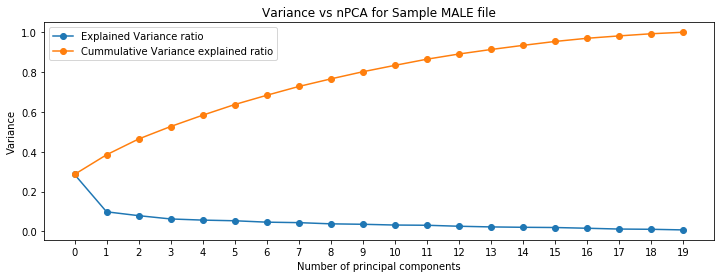

In [22]:
### call Performance function to test performace
pca1 = PCA(n_components=20 )
plt.figure(figsize=(12, 4))
pca_feature = pca1.fit(X_train)
plt.plot(pca_feature.explained_variance_ratio_,marker='o',label='Explained Variance ratio')
plt.plot(pca_feature.explained_variance_ratio_.cumsum(), marker='o',label='Cummulative Variance explained ratio')
plt.legend()
plt.ylabel('Variance')
plt.xlabel('Number of principal components')
plt.title('Variance vs nPCA for Sample MALE file')

_=plt.xticks(np.arange(0, 20, step=1))

<li> As we see the number of components at 13 expresses 90 % of the variance in the data </li>
<li> testing with 13 features the performance </li>

<li> Check Performace of predicting <b>gender</b> after reducing the number of features  </li>

In [0]:
### taking 13 fearures
Xpca= model_df[model_df.columns[0:13]].values

ypca = LabelEncoder().fit_transform(model_df['Gender_label'])

In [28]:
#### Create Train and test Data and invoke performance function
Xpca_train,Xpca_test,ypca_train,ypca_test= train_test_split(Xpca,ypca,test_size=0.33,stratify=ypca,shuffle=True)
performance(classifiers,Xpca_train,Xpca_test,ypca_train,ypca_test)

Accuracy of XGboost classifier is 0.7730942790514552
confusion matrix
[[66337 17292]
 [20169 61297]]
Accuracy of DecisonTree classifier is 0.8170750174142161
confusion matrix
[[68641 14988]
 [15212 66254]]
Accuracy of RandomForest classifier is 0.8546776098609892
confusion matrix
[[73430 10199]
 [13793 67673]]


<li>We see that performance has <b>Decrease</b> by reducing number of features for predicting Gender </li>
<li> Test Performance using <a href = https://en.wikipedia.org/wiki/Cepstral_mean_and_variance_normalization >Cepstral mean and variance normalization</a>
  <li>CMVN minimizes distortion by noise contamination for robust feature extraction by linearly transforming the cepstral coefficients to have the same segmental statistics.</li>